In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time


In [15]:
# sorting data from a file
datapath = "output/eye_data.csv"

# convert to dataframe
import pandas as pd
df = pd.read_csv(datapath)

df.head()

# open the output fodler and read all of the files

# create a list of all the image files
# and their labels
image_numbers = df['frame_idx'].tolist()
# load image
print("image_numbers", image_numbers[-1])

images = []
coords = []
coordsv = []
for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"Processing {idx}/{len(df)}")
    frame_num = int(row['frame_idx'])
    image_path = f"output/{frame_num}.png"
    image = cv2.imread(image_path)
    if image is None:
        continue
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h = image.shape[0]
    scale = 128 / h
    # resize the image to 128x128
    image = cv2.resize(image, (128, 128))/255
    images.append(image)
    coords.append((row['ellipse_x']/ h
                #    , row['ellipse_y']/h
                   ))
    coordsv.append(row['ellipse_y']/ h)

    # coords.append((row['ellipse_x'] * scale, row['ellipse_y'] * scale, row['ellipse_w'] * scale/2, row['ellipse_h'] * scale/2))



image_numbers 11250
Processing 0/11250
Processing 100/11250
Processing 200/11250
Processing 300/11250
Processing 400/11250
Processing 500/11250
Processing 600/11250
Processing 700/11250
Processing 800/11250
Processing 900/11250
Processing 1000/11250
Processing 1100/11250
Processing 1200/11250
Processing 1300/11250
Processing 1400/11250
Processing 1500/11250
Processing 1600/11250
Processing 1700/11250
Processing 1800/11250
Processing 1900/11250
Processing 2000/11250
Processing 2100/11250
Processing 2200/11250
Processing 2300/11250
Processing 2400/11250
Processing 2500/11250
Processing 2600/11250
Processing 2700/11250
Processing 2800/11250
Processing 2900/11250
Processing 3000/11250
Processing 3100/11250
Processing 3200/11250
Processing 3300/11250
Processing 3400/11250
Processing 3500/11250
Processing 3600/11250
Processing 3700/11250
Processing 3800/11250
Processing 3900/11250
Processing 4000/11250
Processing 4100/11250
Processing 4200/11250
Processing 4300/11250
Processing 4400/11250
Pr

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, coords, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)
y_test  = np.array(y_test, dtype=np.float32)

X_trainv, X_testv, y_trainv, y_testv = train_test_split(images, coordsv, test_size=0.2, random_state=42)
X_trainv = np.array(X_trainv, dtype=np.float32)
y_trainv = np.array(y_trainv, dtype=np.float32)
X_testv  = np.array(X_testv, dtype=np.float32)
y_testv  = np.array(y_testv, dtype=np.float32)
def build_model(input_shape=(128,128,1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: 3 × (Conv → ReLU → MaxPool)
    x = layers.Conv2D(32, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)   # 64×64×32

    x = layers.Conv2D(64, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 32×32×64

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 16×16×128

    # Flatten and dense head
    x = layers.Flatten()(x)         # 16*16*128 = 32768
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='linear')(x)  # (x, y)

    model = models.Model(inputs, outputs, name="CoordNet")
    return model

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()




Model: "CoordNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      1600      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       738

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelv = build_model()
modelv.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

loss, mae = model.evaluate(X_test, y_test)

# print("Actual coords:", y_test[:100])

# find mean absolute error for the x and y coordinates



Epoch 1/100
282/282 [==============================] - 5s 15ms/step - loss: 0.4613 - mae: 0.1297 - val_loss: 0.0045 - val_mae: 0.0289
Epoch 2/100
282/282 [==============================] - 4s 14ms/step - loss: 0.0085 - mae: 0.0657 - val_loss: 0.0039 - val_mae: 0.0318
Epoch 3/100
282/282 [==============================] - 4s 14ms/step - loss: 0.0074 - mae: 0.0632 - val_loss: 0.0028 - val_mae: 0.0219
Epoch 4/100
282/282 [==============================] - 3s 12ms/step - loss: 0.0072 - mae: 0.0621 - val_loss: 0.0038 - val_mae: 0.0417
Epoch 5/100
282/282 [==============================] - 3s 11ms/step - loss: 0.0066 - mae: 0.0591 - val_loss: 0.0043 - val_mae: 0.0501
Epoch 6/100
282/282 [==============================] - 3s 11ms/step - loss: 0.0064 - mae: 0.0580 - val_loss: 0.0024 - val_mae: 0.0186
Epoch 7/100
282/282 [==============================] - 3s 10ms/step - loss: 0.0058 - mae: 0.0559 - val_loss: 0.0021 - val_mae: 0.0170
Epoch 8/100
282/282 [==============================] - 3s 10ms

In [18]:
modelv.fit(
    X_trainv, y_trainv,
    validation_data=(X_testv, y_testv),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)
lossv, maev = modelv.evaluate(X_testv, y_testv)


Epoch 1/100
282/282 [==============================] - 4s 12ms/step - loss: 0.1042 - mae: 0.0858 - val_loss: 0.0019 - val_mae: 0.0215
Epoch 2/100
282/282 [==============================] - 3s 10ms/step - loss: 0.0044 - mae: 0.0488 - val_loss: 0.0016 - val_mae: 0.0174
Epoch 3/100
282/282 [==============================] - 3s 11ms/step - loss: 0.0040 - mae: 0.0469 - val_loss: 0.0014 - val_mae: 0.0153
Epoch 4/100
282/282 [==============================] - 3s 10ms/step - loss: 0.0038 - mae: 0.0455 - val_loss: 0.0014 - val_mae: 0.0168
Epoch 5/100
282/282 [==============================] - 3s 10ms/step - loss: 0.0035 - mae: 0.0433 - val_loss: 0.0018 - val_mae: 0.0259
Epoch 6/100
282/282 [==============================] - 3s 10ms/step - loss: 0.0032 - mae: 0.0414 - val_loss: 0.0012 - val_mae: 0.0149
Epoch 7/100
282/282 [==============================] - 3s 10ms/step - loss: 0.0030 - mae: 0.0398 - val_loss: 0.0013 - val_mae: 0.0204
Epoch 8/100
282/282 [==============================] - 3s 10ms

1/1 [==============================] - 0s 88ms/step
Actual: 70.77308654785156, Predicted: [69.72562]


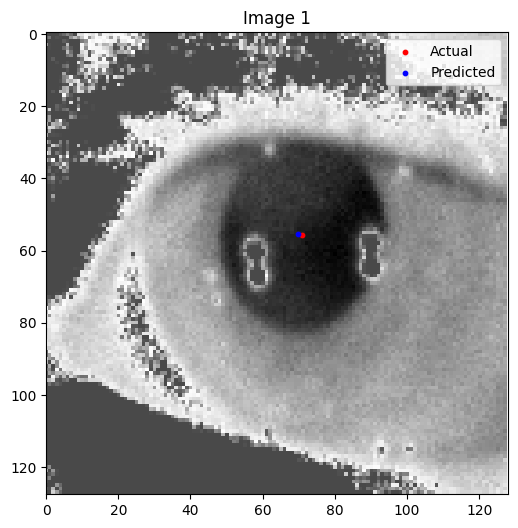

Actual: 65.22087097167969, Predicted: [66.80553]


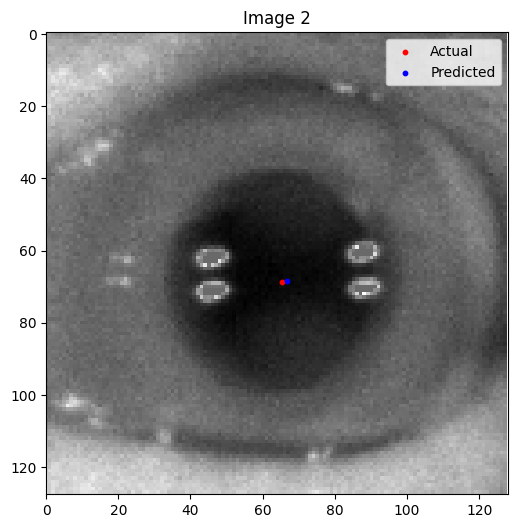

Actual: 68.31241607666016, Predicted: [67.30234]


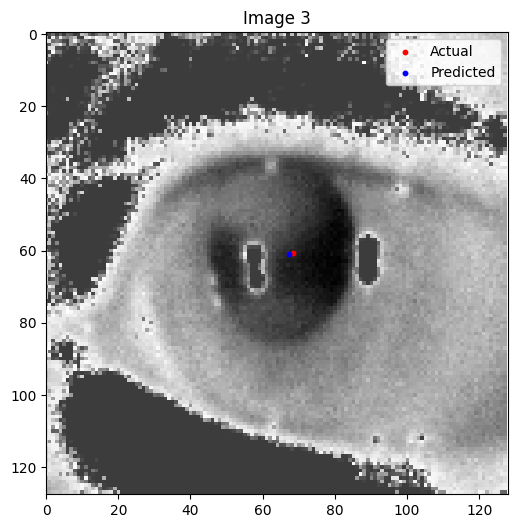

Actual: 74.48369598388672, Predicted: [73.58006]


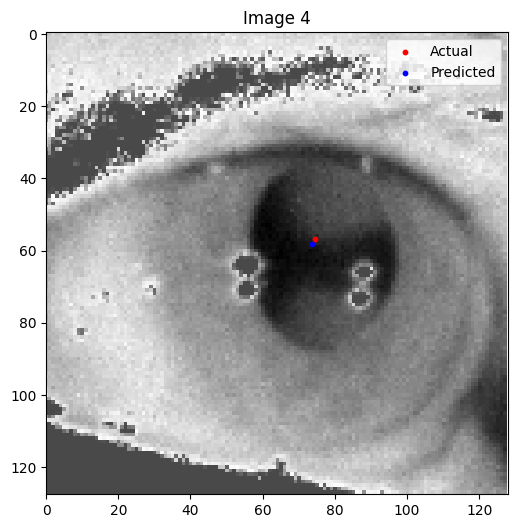

Actual: 69.27570343017578, Predicted: [69.14441]


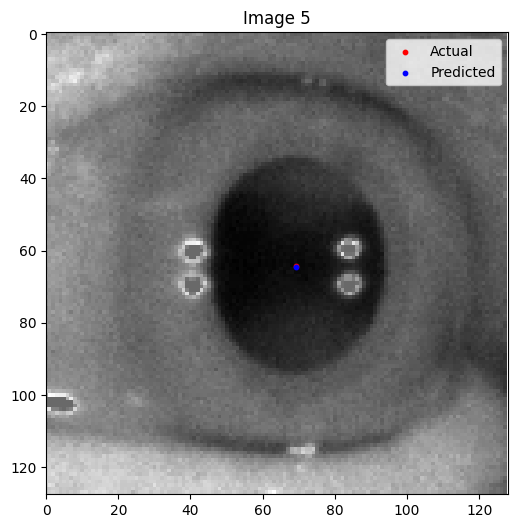

Actual: 76.64307403564453, Predicted: [76.462875]


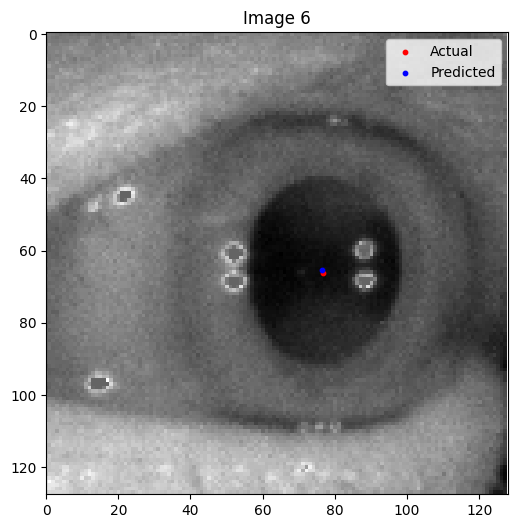

Actual: 62.99076843261719, Predicted: [61.991623]


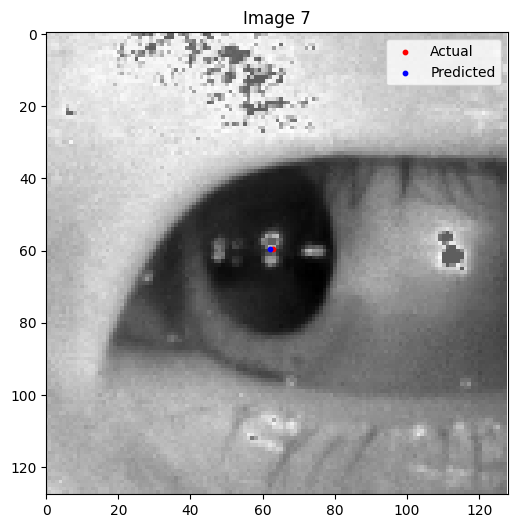

Actual: 74.57550811767578, Predicted: [70.57911]


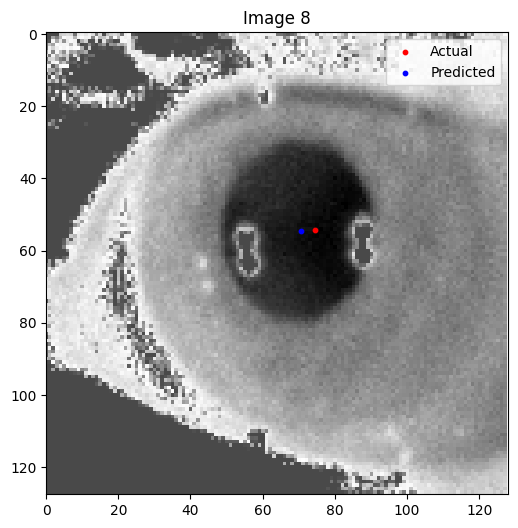

Actual: 77.14778900146484, Predicted: [76.27496]


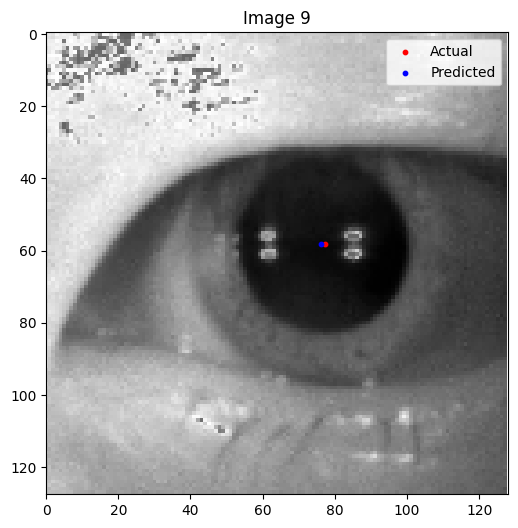

Actual: 70.47384643554688, Predicted: [70.8491]


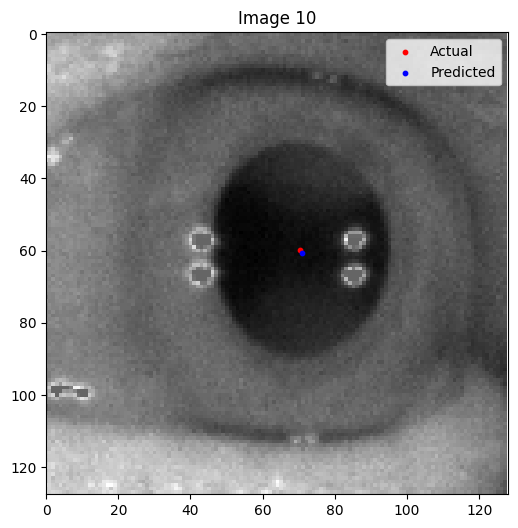

In [19]:
# plot first 5 predictions against the actual coordinates
preds = model.predict(X_test[:10])
predsv = modelv.predict(X_testv[:10])
for i in range(10):
    plt.figure(figsize=(6, 6))
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.scatter(y_test[i]*128, y_testv[i]*128, color='red', label='Actual', s=10)
    plt.scatter(preds[i]*128, predsv[i]*128, color='blue', label='Predicted', s=10)

    print(f"Actual: {y_test[i]*128}, Predicted: {preds[i]*128}")
    plt.xlim(0, 128)

    plt.title(f"Image {i+1}")
    plt.legend()
    plt.show()

In [20]:
# save CNN
model.save("eye_tracking_model.keras", include_optimizer=False)
modelv.save("eye_tracking_modelv.keras", include_optimizer=False)
# save as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("eye_tracking_model.tflite", "wb") as f:
    f.write(tflite_model)
# save as tflite
converterv = tf.lite.TFLiteConverter.from_keras_model(modelv)
tflite_modelv = converterv.convert()
with open("eye_tracking_modelv.tflite", "wb") as f:
    f.write(tflite_modelv)
# 


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpdj3mvhh_\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpdj3mvhh_\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmp51eumt99\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmp51eumt99\assets


In [21]:
# # go through images and show video



# while True:
#     for idx, row in df.iterrows():
#         if idx % 100 == 0:
#             print(f"Processing {idx}/{len(df)}")
#         frame_num = int(row['frame_idx'])
#         image_path = f"output/{frame_num}.png"
#         image = cv2.imread(image_path)
#         if image is None:
#             continue
#         # convert to grayscale
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         h = image.shape[0]
#         scale = 128 / h
#         # resize the image to 128x128
#         image = cv2.resize(image, (128, 128))/255
#         image = np.expand_dims(image, axis=-1)  # Add channel dimension

#         pred = model.predict(np.array([image]))
#         predv = modelv.predict(np.array([image]))

#         # draw the predicted coordinates on the image
#         x, y = int(pred[0][0] * 128), int(predv[0][0] * 128)
#         cv2.circle(image, (x, y), 2, (255, 0, 0), -1)

#         cv2.imshow("Eye Tracking", image)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break